<h1> D7041E Lab3</h1>
Sune Larsson, sunlar-3@student.ltu.se

Elliot Eriksson, lelrek-1@student.ltu.se

# Imports

In [13]:
import os
import pandas as pd
import numpy as np
import string

# Load datasets and preproccesing 


### Load training data

In [14]:
def load_data():
    folder_path = 'training-data-news'

    train_data = {'sentence': [], 'language': []}
    # Loop through each file in the folder
    for folderName in os.listdir(folder_path):
        folderPathName = os.path.join(folder_path, folderName)
        if os.path.isdir(folderPathName):
            code = folderName.split('_')[0][:3]
            for filename in os.listdir(folderPathName):
                if filename.endswith('sentences.txt'): 
                    file_path = os.path.join(folderPathName, filename)
                    # Read the data from the text file
                    with open(file_path, "r", encoding="utf-8") as file:
                        for line in file.readlines():
                            if line.strip() != '':
                                train_data['sentence'].append(line.strip())
                                train_data['language'].append(code)

    return train_data

## Preprocessing training data
1. **Lower casing and removing accents**
2. **Removing puncatation and special characters** `., etc`
3. **tokenazation using `Tri-grams`**



In [15]:
import re
from unidecode import unidecode
def lower_case(text):
    return text.lower()

def remove_non_words(text):
    return ' '.join(re.findall(r'\b[a-zA-Z]+\b', text))

def clean_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def latin_unicode(text):
    return unidecode(text)

def preprocess_sentence(train_data):
    for (i, sentence) in enumerate(train_data['sentence']):
        train_data['sentence'][i] = latin_unicode(sentence)
        train_data['sentence'][i] = lower_case(train_data['sentence'][i])
        train_data['sentence'][i] = remove_non_words(train_data['sentence'][i])
        train_data['sentence'][i] = clean_whitespace(train_data['sentence'][i])
    return train_data


def preprocess_data(dataframes):
    for i in range(len(dataframes)):
        dataframes[i] = latin_unicode(dataframes[i])
        dataframes[i] = lower_case(dataframes[i])
        dataframes[i] = remove_non_words(dataframes[i])
        dataframes[i] = clean_whitespace(dataframes[i])
    return dataframes


## Encoding of n-grams using d-dimension {+1,-1} distributed representation
- Use of n = 3 `tri grams`

In [16]:
# d = 1000

alphabet = ' abcdefghijklmnopqrstuvwxyz'

n_gram_size = 3
# item_memory = np.random.choice([-1, 1], size=(len(alphabet), d))
# permutations = [np.random.choice([-1, 1], size=d) for _ in range(n_gram_size)]


In [17]:
def generate_ngrams(text, n=3):
    ngrams = [text[i:i+n_gram_size] for i in range(len(text) - n_gram_size + 1)]
    return ngrams

def encode_ngram(ngram,d, item_memory, permutations):
        encoded_vector = np.ones(d)
        for j, char in enumerate(ngram,d):
            if char == ' ':
                index = 0  
            elif char.isalpha():
                index = ord(char.lower()) - ord('a') + 1  
            else:
                continue  
            # Handle out-of-bounds index (if any)
            if 0 <= index < len(alphabet):
                permuted_vector = item_memory[index] * permutations[j % len(permutations)]
                encoded_vector *= permuted_vector
        return encoded_vector    


def calculate_vector(texts, d, item_memory, permutations):
# Initialize item memory and permutations
    ngrams = generate_ngrams(texts)
    bundled_vector = np.zeros(d)
    for ngram in ngrams:

        ngram_vector = encode_ngram(ngram,d, item_memory, permutations)
        bundled_vector += ngram_vector
    norm = np.linalg.norm(bundled_vector)
    return bundled_vector / norm if norm != 0 else bundled_vector



### Conventional Local Representation Size
The size of a vector in a conventional (local) representation depends on the number of possible n-grams in the given alphabet. The formula for this is \( S = a^n \), where \( a \) is the size of the alphabet and \( n \) is the order of the n-gram.

For example, if we are using the Latin alphabet (26 letters + space) and \( n = 3 \) (trigrams), the size of the vector is:

\[
S = 27^3 = 19,683
\]

### Difficulties of Working with Conventional Representations of n-Grams in Machine Learning
As mentioned earlier, the size of the one-hot encoded vector for trigrams in the Latin alphabet is \( 19,683 \). This high dimensionality poses an obvious computational bottleneck due to the rapid exponential growth of the number of possible n-grams as \( n \) increases.

Additionally, these vectors are typically sparse, meaning most entries are zero. This sparsity can lead to inefficiencies in both memory usage and processing time. Furthermore, the large vector size increases the risk of overfitting, as models may learn to memorize the training data instead of generalizing to new, unseen data.



## Classification using hyperdimensional centroids

### Load test data

In our test the sentences in the test data is at least 61 symbols long and each language is tested for 1000 sentences.

In [18]:
import re
import nltk
from nltk.tokenize import sent_tokenize
from unidecode import unidecode
nltk.download('punkt_tab')


def preprocess_test_data(text):
    # Step 1: Remove metadata tags like <SPEAKER ...> and <P>
    text_no_tags = re.sub(r'<[^>]+>', '', text)

    text = latin_unicode(text_no_tags)
    text = lower_case(text)
    text = sent_tokenize(text)

    text_pre = []
    for sentence in text:
        sentence = remove_non_words(sentence)
        sentence = clean_whitespace(sentence)
        text_pre.append(sentence)

    return text_pre


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ellio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
import glob
def extract_text_from_file(file_path):
    try:
        with open(file_path, encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

def load_specific_test_data(test_dir, languages):
    # List to store dataframes
    lines_per_language = 1000
    languages_codes_2digits = {'bul': 'bg', 'ces': 'cs', 'dan': 'da', 'deu': 'de', 'ell': 'el', 'eng': 'en', 'est': 'et', 'fin': 'fi', 'fra': 'fr', 'hun': 'hu', 'ita': 'it', 'lav': 'lv', 'lit': 'lt', 'nld': 'nl', 'pol': 'pl', 'por': 'pt', 'ron': 'ro', 'slk': 'sk', 'slv': 'sl', 'spa': 'es', 'swe': 'sv'}
    test_data = []
    # Loop through each file in the folder
    for lang_idx, lang in enumerate(languages, start=1):
        language_dir = os.path.join(test_dir, languages_codes_2digits[lang])
        file_pattern = os.path.join(language_dir, "ep-*.txt")
        file_paths = glob.glob(file_pattern)

        total_rows = 0
        language_data = []
        for file_idx, file_path in enumerate(file_paths, start=1):
            text = extract_text_from_file(file_path)
            if text:
                newtext = preprocess_test_data(text)
                newtext = [item for item in newtext if len(item) > 61]
                if total_rows + len(newtext) > lines_per_language:
                    newtext = newtext[:lines_per_language - total_rows]
                    language_data = language_data + newtext
                    break
                language_data = language_data + newtext
                total_rows += len(newtext)
        if len(language_data) != lines_per_language:
            print(f"Warning: Language {lang} has {len(language_data)} lines instead of 1000")
            if len(language_data) == 1:
                print(language_data)
        test_data.append({'text': language_data, 'language': lang})
    
    return pd.DataFrame(test_data)


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def similarity_measure(X, V):
    # Calculate the dot product X · V
    dot_product = np.dot(X, V)
    
    norm_X = np.linalg.norm(X)
    norm_V = np.linalg.norm(V)

    similarity = dot_product / (norm_X * norm_V)
    
    return similarity

def classify_language(test_sentence, languages,centroids, d, item_memory, permutations):
    test_vector = calculate_vector(test_sentence, d, item_memory, permutations)

    similarities = [similarity_measure(test_vector, centroid) for centroid in centroids]

    return languages[np.argmax(similarities)]


In [21]:
def prediction_accuracy(predicted_labels_all, test_labels, language_codes):
    test_labels = np.repeat(test_labels, -(-len(predicted_labels_all) // len(test_labels)))
    test_labels = test_labels[:len(predicted_labels_all)]  

    cm = confusion_matrix(test_labels, predicted_labels_all, labels=language_codes)
    accuracy = accuracy_score(test_labels, predicted_labels_all)
    f1 = f1_score(test_labels, predicted_labels_all, average='weighted')

    # Print results
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'F1 Score: {f1*100:.2f}% \n' )
    return cm

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix_heatmap(cm, language_codes,d):
    # Create a confusion matrix heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=language_codes,
                yticklabels=language_codes)
    plt.title(f'Confusion Matrix for {d=}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [23]:
from typing import OrderedDict

def split_sentences_by_language(train_data_pre):
    split_data = {}

    # Get a list of unique languages
    unique_languages = set(train_data_pre['language'])

    for language in unique_languages:
        # Get the sentences for the current language
        language_sentences = [train_data_pre['sentence'][i] for i in range(len(train_data_pre['sentence'])) if train_data_pre['language'][i] == language]

        # Ensure we have 10000 sentences for each language
        if len(language_sentences) == 10000:
            # Split the sentences into 3 groups: 6000, 2000, 2000
            group1 = language_sentences[:6000]
            group2 = language_sentences[6000:8000]
            group3 = language_sentences[8000:]

            group1_text = ' '.join(group1)

            # Store the groups for this language
            split_data[language] = {
                "trainingdata": group1_text,
                "testingdata": group2,
                "validationdata": group3
            }

    return split_data

def train_model(text_data, language_codes, d, item_memory, permutations):
    language_centroids = OrderedDict((language, np.zeros(d)) for language in language_codes)
    
    for text, language in zip(text_data, language_codes):
        language_centroids[language] += calculate_vector(text, d, item_memory, permutations)

    centroids = np.array(list(language_centroids.values()))
    languages = list(language_centroids.keys())
    
    return centroids, languages

def predict_language_for_texts_and_evaluate(centroids, languages, language_codes, test_texts, test_labels, d, item_memory, permutations):
    predicted_labels = np.array([classify_language(text, languages, centroids, d, item_memory, permutations) for text in test_texts])
    
    cm = prediction_accuracy(predicted_labels, test_labels, language_codes)
    
    return cm 


Training model with d=100:

Testing vs news data
Accuracy: 68.69%
F1 Score: 68.56% 

Testing vs validation data:
Accuracy: 68.63%
F1 Score: 68.48% 

Testing vs Europarl data:
Accuracy: 73.82%
F1 Score: 72.98% 



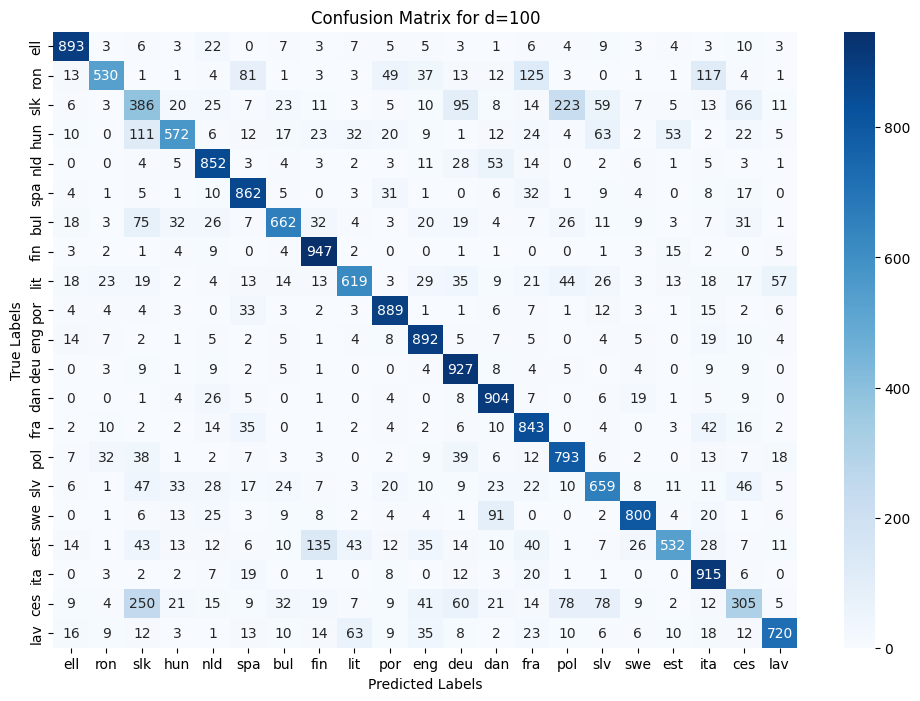

Training model with d=1000:

Testing vs news data
Accuracy: 87.59%
F1 Score: 87.55% 

Testing vs validation data:
Accuracy: 87.24%
F1 Score: 87.20% 

Testing vs Europarl data:
Accuracy: 86.86%
F1 Score: 86.37% 



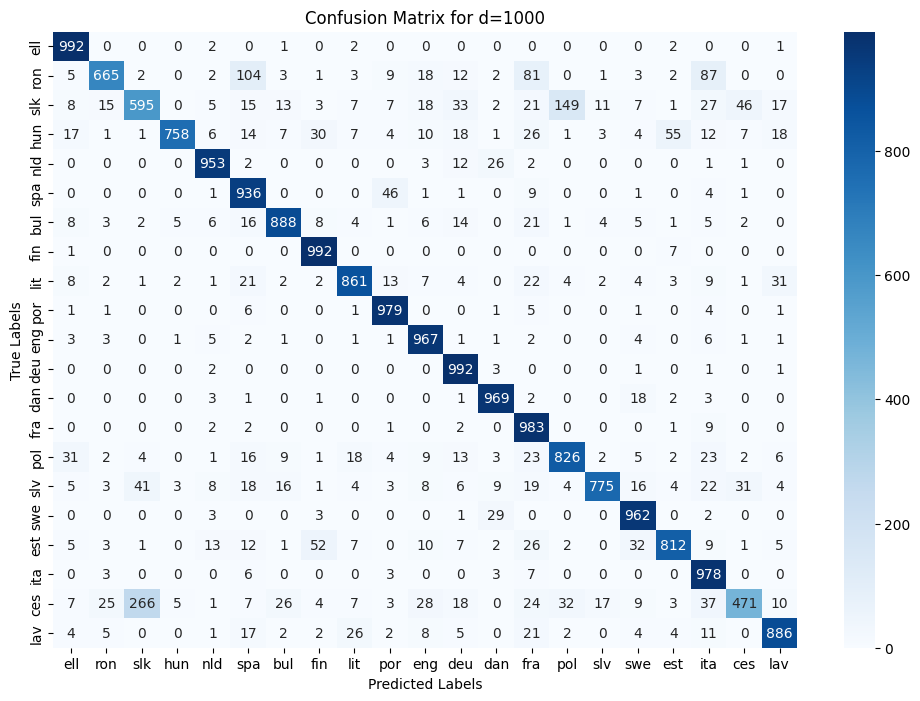

In [24]:
train_data = load_data()
train_data_pre = preprocess_sentence(train_data)


split_data = split_sentences_by_language(train_data_pre)

train_data_pre = [split_data[lang]['trainingdata'] for lang in split_data]
train_data_pre = np.array(train_data_pre)

test_data_pre = [split_data[lang]['testingdata'] for lang in split_data]
test_data_pre = np.array(test_data_pre)
test_data_pre = np.concatenate(test_data_pre).ravel()

valid_data = [split_data[lang]['validationdata'] for lang in split_data]
valid_data = np.array(valid_data)
valid_data = np.concatenate(valid_data).ravel()

language_codes = list(split_data.keys())


test_data_europarl = load_specific_test_data('test-data', language_codes)
test_data_pre_europarl = np.array(test_data_europarl['text'])

test_labels = test_data_europarl['language']

test_data_pre_europarl = np.concatenate(test_data_pre_europarl).ravel()

def evaluate_language_model(d):
    item_memory = np.random.choice([-1, 1], size=(len(alphabet), d))
    permutations = [np.random.choice([-1, 1], size=d) for _ in range(n_gram_size)]
    print(f'Training model with {d=}:\n')
    centroids, languages = train_model(train_data_pre, language_codes, d, item_memory, permutations)
    

    print(f'Testing vs news data')
    predict_language_for_texts_and_evaluate(centroids, languages, language_codes, test_data_pre, test_labels, d, item_memory, permutations)

    print(f'Testing vs validation data:')
    predict_language_for_texts_and_evaluate(centroids, languages, language_codes, valid_data, test_labels, d, item_memory, permutations)

    print(f'Testing vs Europarl data:')
    cm = predict_language_for_texts_and_evaluate(centroids, languages, language_codes, test_data_pre_europarl, test_labels, d, item_memory, permutations)
    confusion_matrix_heatmap(cm, language_codes,d)

evaluate_language_model(d=100)
evaluate_language_model(d=1000)
